# Building Classification and recognization

## Mount google-drive & Load dataset

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

# shared path to drive
SHARED_PATH = "/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

# direct path to drive
DIRECT_PATH = "/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Determine the data path based on the existence of shared or direct paths
root_path = (
    SHARED_PATH
    if os.path.exists(SHARED_PATH)
    else DIRECT_PATH
    if os.path.exists(DIRECT_PATH)
    else None
)


data_path = ""
# Print the chosen path or an error message
if root_path:
    print(f"Using path: {root_path}")
    data_path = root_path + "/CNC_BuildingClassify_expr1_filtered_data"
    for filename in os.listdir(data_path):
        print(filename)
else:
    print("Neither shared nor direct path exists. Please check the paths.")


Using path: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours
training_expr1.ipynb
Testing_data
Copy of training_expr1.ipynb
test_expr1.ipynb
visualize_expr1.ipynb
Training_data


## Specify training and testing data path

In [ ]:
path_train_data = data_path + "/Training_data"
path_test_data = data_path + "/Testing_data"

## Importing pytorch and setup CPU or GPU

In [40]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Define device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Define data transformations

In [ ]:
import torchvision.transforms as transforms

mean = [0.485, 0.456, 0.406]
standev = [0.229, 0.224, 0.225]
px = 224

train_transform = transforms.Compose(
    [
        transforms.Resize((px, px)),
        # transforms.RandomRotation(10),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(mean), std=(standev)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((px, px)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(mean), std=(standev)),
    ]
)

print(train_transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Load dataset with Torch

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(root=path_train_data, transform=train_transform)
test_dataset = ImageFolder(root=path_test_data, transform=test_transform)

print(train_dataset)
print(f"data classes are: {train_dataset.classes}")
print(test_dataset)
print(f"data classes are: {test_dataset.classes}")

Dataset ImageFolder
    Number of datapoints: 82
    Root location: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/CNC_BuildingClassify_expr1_filtered_data/Training_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
data classes are: ['admin', 'canteen', 'chemistry', 'gurudeb', 'heritage']
Dataset ImageFolder
    Number of datapoints: 145
    Root location: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/CNC_BuildingClassify_expr1_filtered_data/Testing_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), i

## Visualization of transformation

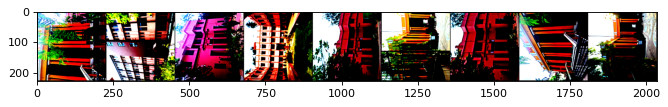

labels: tensor([4, 0, 2, 3, 2, 4, 2, 4, 4])


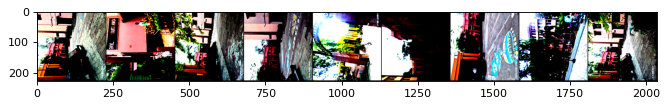

labels: tensor([0, 0, 3, 0, 3, 1, 1, 0, 1])


In [ ]:
def disp_img_grid(dataset):
    loader = DataLoader(dataset, batch_size=9, shuffle=True)
    batch = next(iter(loader))
    img, lbl = batch

    grid = torchvision.utils.make_grid(img, nrow=1)
    plt.figure(figsize=(10, 10), dpi=80)
    # Use permute instead of calling the tensor
    plt.imshow(np.transpose(grid.permute(1, 2, 0).numpy(), (1, 0, 2)))
    # plt.axis('off')  # Hide axes
    plt.show()  # Show the plot
    print(f"labels: {lbl}")


disp_img_grid(train_dataset)
disp_img_grid(test_dataset)

## Data loader

In [ ]:
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

train_loader

## Use Readymade CNN Model(ResNet) and modify it

In [ ]:
# Load pre-trained ResNet18 model
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# rsnt18_model = models.resnet18(weights ='ResNet18_Weights.DEFAULT')  # pretrained = True/false
rsnt18_model = models.resnet18(weights=None)  # pretrained = False)

# modifying the last layer
last_layer_in = rsnt18_model.fc.in_features
no_of_classes = len(train_dataset.classes)
print(
    f"last layer output for model = {last_layer_in} -> convert to {no_of_classes} output"
)
rsnt18_model.fc = nn.Linear(last_layer_in, no_of_classes)

last layer output for model = 512 -> convert to 5 output


In [46]:
# Move model to device
rsnt18_model = rsnt18_model.to(DEVICE)
print(rsnt18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
loss_fn = nn.CrossEntropyLoss()  # criterion = torch.nn.CrossEntropyLoss()
print(loss_fn)
optimizer = optim.Adam(rsnt18_model.parameters(), lr=0.001)
print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## Training part

In [ ]:
def train_NN(model, train_loader, test_loader, loss_citr, optim, n_epochs=10):
    for epoch in range(n_epochs):
        print(f"epoch number--- {epoch}")
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            total += labels.size(0)

            optim.zero_grad()
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            loss = loss_citr(output, labels)
            loss.backward()
            optim.step()

            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100.0 * running_correct / total
        print(
            f"   -Training...got {running_correct} out of {total} correctly {epoch_accuracy:.2f}%, Epoch loss:{epoch_loss:.2f}%"
        )
        # eval_model_on_test(model,test_loader)
    print("Finished.....")


def eval_model_on_test(model, test_loader):
    model.eval()
    pred_correctly = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            total += labels.size(0)

            output = model(images)
            _, predicted = torch.max(output.data, 1)

            pred_correctly += (predicted == labels).sum().item()
    epoch_accuracy = 100.0 * pred_correctly / total
    print(
        f"   -Testing... got {pred_correctly} out of {total} correctly accuracy=({epoch_accuracy:.2f}%)"
    )

In [49]:
train_NN(rsnt18_model, train_loader, test_loader, loss_fn, optimizer, n_epochs=20)

epoch number--- 0
   -Training...got 28 out of 82 correctly 34.15%, Epoch loss:2.29%
epoch number--- 1
   -Training...got 53 out of 82 correctly 64.63%, Epoch loss:0.95%
epoch number--- 2
   -Training...got 53 out of 82 correctly 64.63%, Epoch loss:0.74%
epoch number--- 3
   -Training...got 70 out of 82 correctly 85.37%, Epoch loss:0.35%
epoch number--- 4
   -Training...got 79 out of 82 correctly 96.34%, Epoch loss:0.17%
epoch number--- 5
   -Training...got 78 out of 82 correctly 95.12%, Epoch loss:0.13%
epoch number--- 6
   -Training...got 80 out of 82 correctly 97.56%, Epoch loss:0.12%
epoch number--- 7
   -Training...got 79 out of 82 correctly 96.34%, Epoch loss:0.12%
epoch number--- 8
   -Training...got 78 out of 82 correctly 95.12%, Epoch loss:0.14%
epoch number--- 9
   -Training...got 79 out of 82 correctly 96.34%, Epoch loss:0.14%
epoch number--- 10
   -Training...got 80 out of 82 correctly 97.56%, Epoch loss:0.10%
epoch number--- 11
   -Training...got 80 out of 82 correctly 97.

In [ ]:
eval_model_on_test(rsnt18_model, test_loader)

   -Testing... got 68 out of 145 correctly accuracy=(46.90%)


## Save trained model

In [ ]:
# print(rsnt18_model.state_dict())
torch.save(rsnt18_model.state_dict(), data_path + "/resnet18_image_classifier.pth")

os.listdir(data_path)

['training_expr1.ipynb',
 'Testing_data',
 'Copy of training_expr1.ipynb',
 'test_expr1.ipynb',
 'visualize_expr1.ipynb',
 'Training_data',
 'resnet18_image_classifier.pth']